<a href="https://colab.research.google.com/github/alexlapshov89/ALapshov_coding/blob/main/math%26ml_13_part02_timeseries_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ временного ряда - ВВП Ганы**

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
#pip install pmdarima

In [78]:
#pip install arch

In [79]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error

In [80]:
pip freeze > requirements.txt

In [81]:
# загрузка данных
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skillfactory/MATH&ML-13 Временные ряды. Часть 2/data/ghana_gdp.zip',
                   parse_dates=["year"],
                   index_col = ["year"]).rename(columns={'GDP (current US$)':'GDP'})
print(data.shape)
data.head(3)

(62, 1)


,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


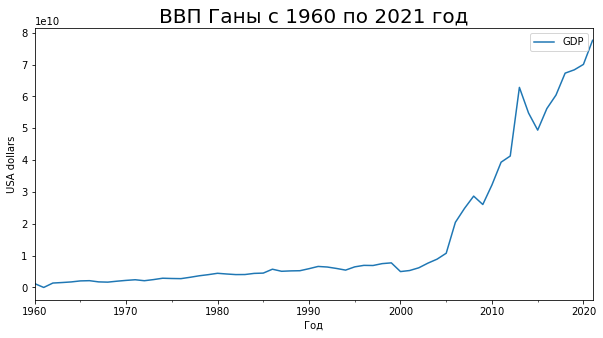

In [82]:
# визуализация ряда
ax = data.plot(figsize=(10,5))
ax.set_title(f'ВВП Ганы с {data.index.min().year} по {data.index.max().year} год',size=20)
ax.set_xlabel('Год')
ax.set_ylabel('USA dollars');

Наблюдается тренд к росту показателя. Характерно, что после 2000 года тренд усиливается. Очевидной сезонной составляющей не наблюдается.

In [83]:
train_df = data.loc[:"2018-01-01"]  # обучающая выборка: значения с 1960 по 2018 год
test_df = data.loc["2019-01-01":]   # тестовая выборка: значения с 2019 по 2021 год
train_df.shape, test_df.shape       # проверка размерности выборок

((59, 1), (3, 1))

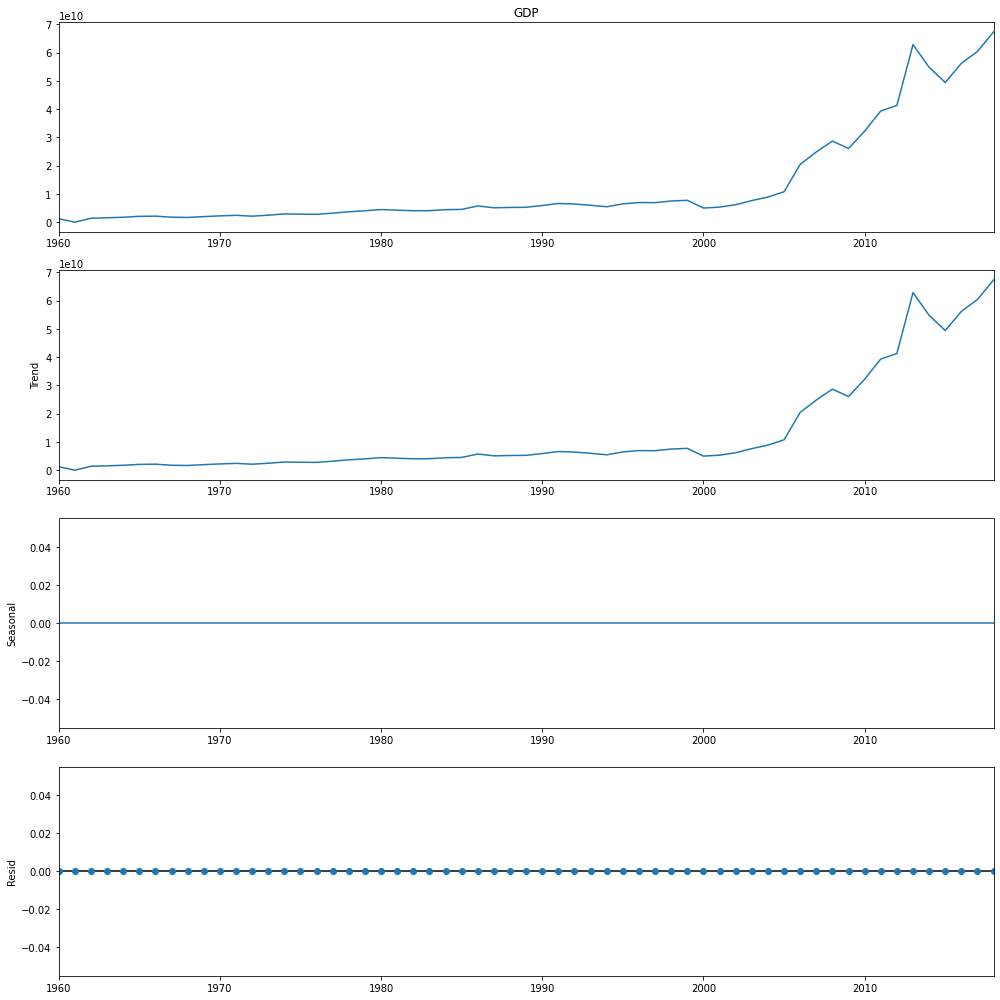

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 14, 14

result = seasonal_decompose(train_df.GDP)
result.plot()
plt.show()

Декомпозиция ряда также подтвердила наличие трендовой составляющей и отсутствие сезонной.

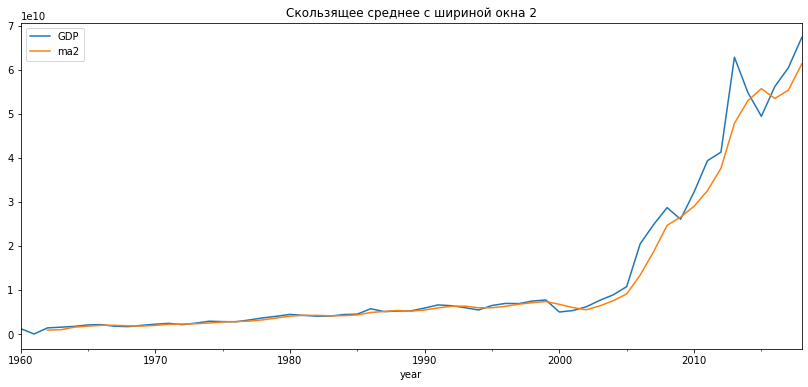

In [85]:
ma = train_df['GDP'].rolling(window=3).mean()
fig,ax = plt.subplots(figsize=(14,6))
train_df.plot(ax=ax)
ma.plot(ax=ax, label='ma2')
ax.legend()
ax.set_title('Скользящее среднее с шириной окна 2');

Модель MA сглаживает резкие перепады. В течение сильного тренда запаздывает за изменением данных.

Порядок дифференцирования(d) равен 3



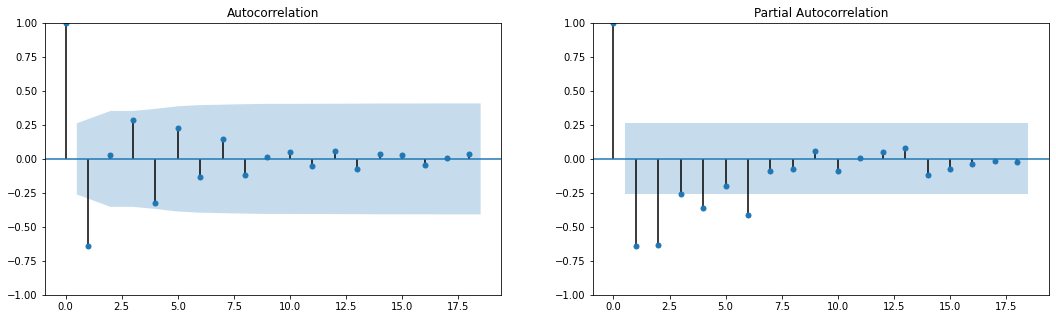

In [86]:
def adfuller_cycle(ser,max_iter=10):
  """
  Функция приводит временной ряд к стационарности путем итерационного дифференцирования,
  критерием стационарности является значение теста Дики-Фуллера
  Args:     ser       - временной ряд (типа series);
            max_iter  - максимальное число итераций алгоритма
  Returns:  ser       - стационарный временной ряд;
            result    - результат теста Дики-Фуллера(кортеж);
            d         - порядок дифференцирования ряда"""
  # порядок дифференцирования
  d = 0
  # количество итераций
  iter = 0
  while (iter<max_iter):
    result = adfuller(ser)
    # критерий остановки
    if result[0]<result[4]['1%']:
      break
    d, iter = d+1, iter+1
    ser = ser.diff(1).dropna()
  return ser, result, d

def plot_acf_pacf(series):
    """Функция визуализации ACF и PACF временного ряда series"""
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, ax = axes[0])
    sgt.plot_pacf(series, method='ywm', ax = axes[1])
    plt.show()

stat_ts, _, d = adfuller_cycle(train_df['GDP'])
print(f"Порядок дифференцирования(d) равен {d}\n")

plot_acf_pacf(stat_ts)

Для прогнозирования выбирается модель ARIMA, т.к. ряд нестационарный. Определяем следующие параметры для модели:
- p=2 (определен по графику частичной автокорреляции)
- q=1 (определен по графику автокорреляции)
- d=3

In [87]:
arima_res = ARIMA(train_df['GDP'], order=(2, 3, 1)).fit()
arima_res.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 10 Feb 2023   AIC                           2659.231
Time:                        20:28:31   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Полученная модель характеризуется показателем AIC, равным **2659**.

In [88]:
# проведем перебор параметров для поиска модели с лучшим показателем
import pmdarima as pm

smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10,
                         seasonal=False,
                         d=3, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.08 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.08 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.06 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.16 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.419 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 10 Feb 2023   AIC                           2659.231
Time:                        20:28:33   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

При подборе параметров **q** , **p** в **pmdarina** лучшей оказалась модель с параметрами **order=(2, 3, 1)**, т.е. ранее созданную модель улучшить не удалось.

In [89]:
arima_res = ARIMA(train_df['GDP'], order=(2, 3, 1)).fit()
arima_res.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 10 Feb 2023   AIC                           2659.231
Time:                        20:28:33   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

In [90]:
# pred_df - сводная таблица с реальными и предсказанными данными
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = arima_res.predict(start = test_df.index[0], end = test_df.index[-1])

pred_df["GDP"] = data["GDP"]

forecast = arima_res.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

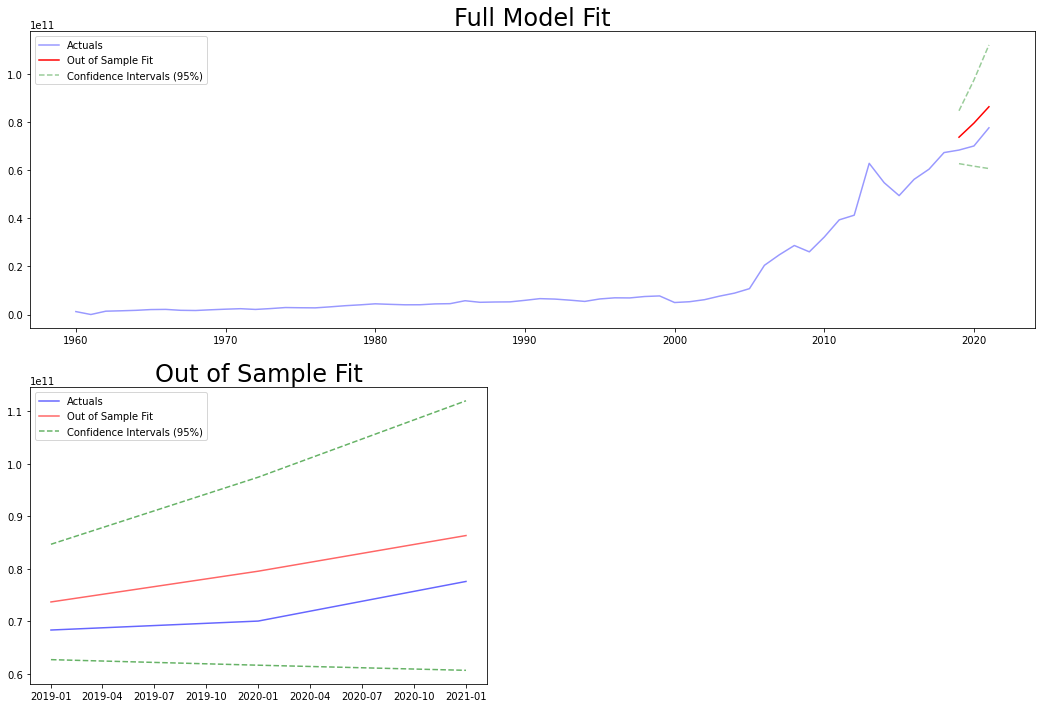

In [91]:
# визуализация
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Прогнозируемые и реальные значения оказались в границах доверительного интервала предсказания. 

## **Интерполяция**

In [92]:
# проверка пропусков индексов-даты
print('В датах содержатся пропуски в количестве:')
print(data.asfreq('YS').isnull().sum())
# подсчет пропусков данных
print('В данных содержатся пропуски в количестве:')
print(data.isnull().sum())

В датах содержатся пропуски в количестве:
GDP    0
dtype: int64
В данных содержатся пропуски в количестве:
GDP    0
dtype: int64


In [93]:
# преобразование нулевых значений в пропуски
import numpy as np
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)
# подсчет пропущенных значений
data.isnull().sum()

GDP    1
dtype: int64

In [94]:
# интерполированный временной ряд
interpolated_data = data['GDP'].interpolate()
# проверка наличия пропусков
interpolated_data.isnull().sum()

0

In [95]:
# разделение на обучающую и тестовую выборки
train_df = interpolated_data.loc[:"2018-01-01"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59,), (3,))

Порядок дифференцирования(d) равен 3



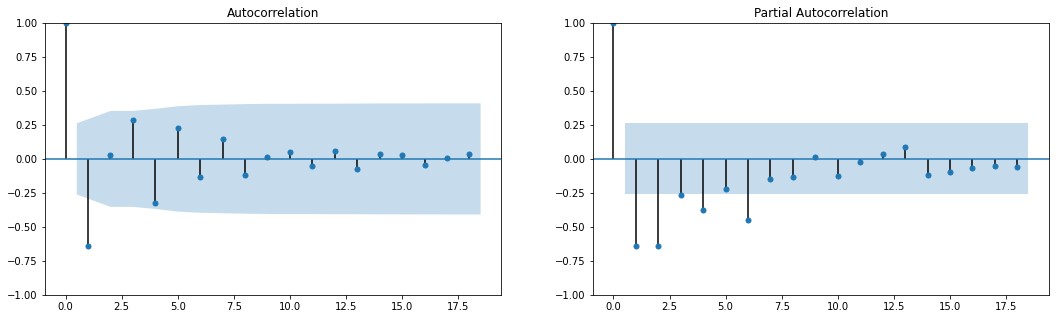

In [96]:
# plt.rcParams["figure.figsize"] = 18, 12
train_df_st,_,d = adfuller_cycle(train_df)
print(f'Порядок дифференцирования(d) равен {d}\n')
plot_acf_pacf(train_df_st)
#sgt.plot_acf(train_df_st.dropna())
#sgt.plot_pacf(train_df_st.dropna(),method='ywm')
#adfuller(train_df_st.dropna())

In [97]:
# модель 
arima_model = ARIMA(train_df, order = (2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Fri, 10 Feb 2023   AIC                           2659.226
Time:                        20:28:35   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+56. Standard errors may be unstable.
"""

In [98]:
# предикт
pred_df = pd.DataFrame(index = interpolated_data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


pred_df["GDP"] = interpolated_data

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

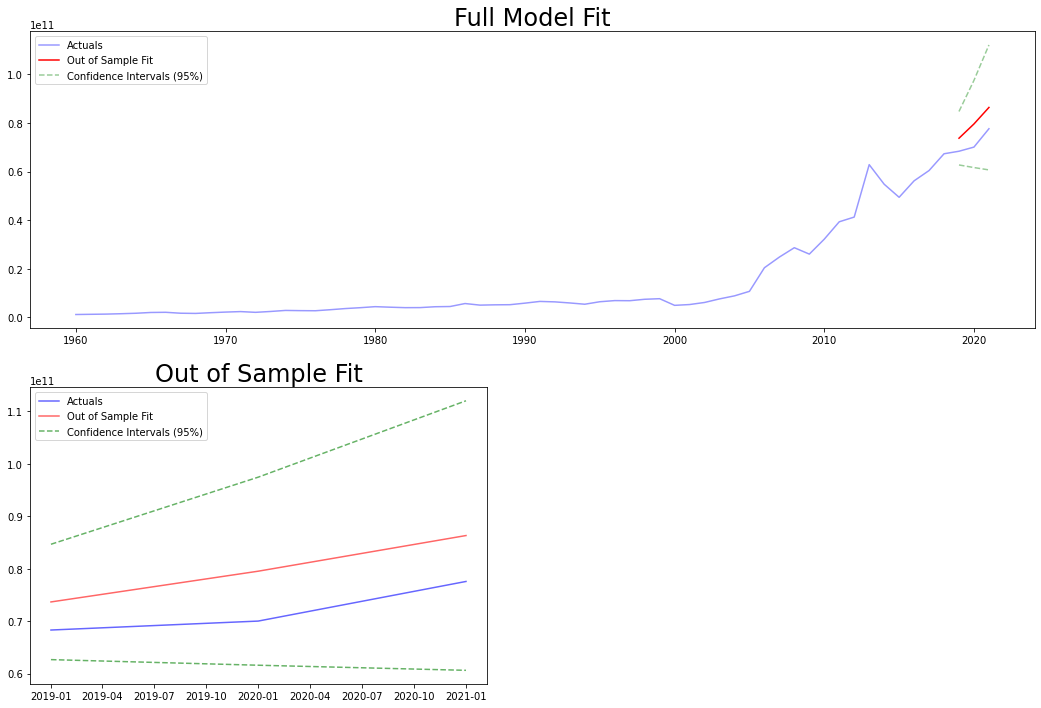

In [99]:
# визуализация
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Отличий в поведении предсказанных значений не наблюдается. Это закономерно, т.к. интерполяция убрала 1 пропущенное значение в начале ряда, что не отразилось при обучении модели.

## **Волатильность**

In [100]:
# расчет волатильности данных
data["GDP_vol"] = data.GDP.pct_change(1).mul(100).abs()
data["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

Максимальная волатильность составляет 90.24207449589245 %



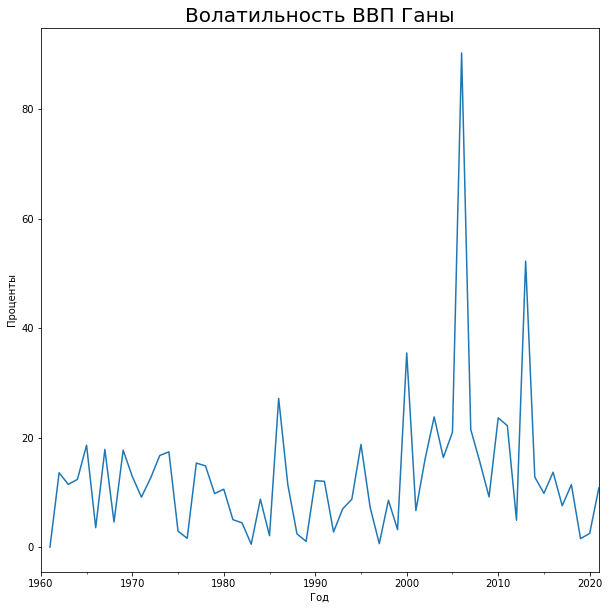

In [101]:
# визуализация
fig,ax = plt.subplots(figsize=(10,10))
data["GDP_vol"].plot(ax=ax)
ax.set_title('Волатильность ВВП Ганы', size=20)
ax.set_xlabel('Год')
ax.set_ylabel('Проценты')
print(f"Максимальная волатильность составляет {data['GDP_vol'].max()} %\n")

In [102]:
# разделение на обучающую и тестовую выборки
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 2), (3, 2))

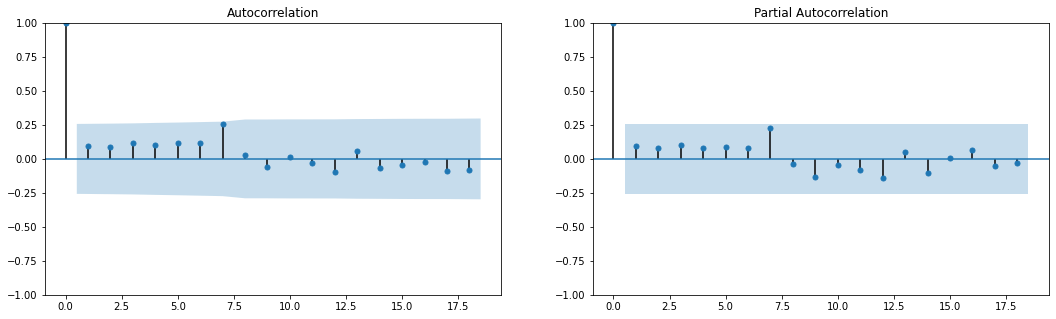

In [103]:
# График PACF
plot_acf_pacf(train_df['GDP_vol'].iloc[1:])

In [104]:
# Проверка ряда на стационарность
result = adfuller(train_df['GDP_vol'][1:])
if result[0]<result[4]['1%']:
  print('Ряд стационарный')
else:
  print('Ряд нестационарный')
print()
result

Ряд стационарный



(-6.816105099260228,
 2.0572875762632108e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [105]:
# моделирование с параметрами, полученными по ACF и PACF: p=7, q=7
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index]) 
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

from arch import arch_model
model = arch_model(garch_df["GDP_vol"].dropna(), p = 7, q = 7, vol = "GARCH")

model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)
model_results.summary()

Iteration:      5,   Func. Count:     91,   Neg. LLF: 238.85932252411234
Iteration:     10,   Func. Count:    179,   Neg. LLF: 215.54503184225177
Iteration:     15,   Func. Count:    264,   Neg. LLF: 215.30040785396184
Iteration:     20,   Func. Count:    349,   Neg. LLF: 214.92020066801985
Iteration:     25,   Func. Count:    434,   Neg. LLF: 214.73614860315595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.7350352111361
            Iterations: 30
            Function evaluations: 507
            Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.735
Distribution:                  Normal   AIC:                           461.470
Method:            Maximum Likelihood   BIC:                           494.437
                                        No. Observations:                   58
Date:                Fri, Feb 10 2023   Df Residuals:                       57
Time:                        20:28:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.7865      1.447      8.143  3.867e-16 [  8.949, 14.624]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         45.3475     36.934      1.228      0.220    [-27.042,1.177e+02]
alpha[1]   3.0834e-13  6.081e-02  5.070e-12      1.000      [ -0.119,  0.119]
alpha[2]   1.1349e-12  2.157e-02  5.261e-11      1.000 [-4.228e-02,4.228e-02]
alpha[3]   2.3705e-08  5.798e-02  4.088e-07      1.000      [ -0.114,  0.114]
alpha[4]   3.4226e-03  1.175e-02      0.291      0.771 [-1.961e-02,2.646e-02]
alpha[5]   1.0555e-08  1.088e-02  9.701e-07      1.000 [-2.133e-02,2.133e-02]
alpha[6]       0.7280      0.787      0.925      0.355      [ -0.814,  2.270]
alpha[7]       0.1022      0.479      0.213      0.831      [ -0.837,  1.041]
beta[1]    9.4659e-14      0.382  2.476e-13      1.000      [ -0.749,  0.749]
beta[2]    7.7394e-13  4.690e-02  1.650e-11      1.000 [-9.192e-02,9.192e-02]
beta[3]    8.7275e-13  2.535e-02  3.442e-11      1.000 [-4.969e-02,4.969e-02]
beta[4]    3.2388e-13  7.371e-02  4.394e-12      1.000      [ -0.144,  0.144]
beta[5]    1.9898e-13  5.185e-02  3.838e-12      1.000      [ -0.102,  0.102]
beta[6]    4.8081e-13  2.751e-02  1.748e-11      1.000 [-5.391e-02,5.391e-02]
beta[7]    7.7476e-14      0.899  8.615e-14      1.000      [ -1.763,  1.763]
=============================================================================

Covariance estimator: robust
"""

In [106]:
# подбор параметров модели перебором
aic = 5000
param_grid = {'p': range(1,10),
              'q': range(1,10)}
for p in param_grid['p']:
  for q in param_grid['q']:
    model = arch_model(garch_df["GDP_vol"].dropna(), p = p, q = q, vol = "GARCH")
    model_results = model.fit(disp='off',last_obs = test_df.index[0], update_freq = 10)
    if model_results.aic<aic:
      aic = model_results.aic
      best_params = p,q,aic
print(f'Лучшие параметры модели (p, q, aic): {best_params}')

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Лучшие параметры модели (p, q, aic): (6, 1, 448.22583017165044)


In [107]:
# программирование модели с наилучшими параметрами
model = arch_model(garch_df["GDP_vol"].dropna(), p = best_params[0], q = best_params[1], vol = "GARCH")
model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     56,   Neg. LLF: 225.89149924968274
Iteration:     10,   Func. Count:    108,   Neg. LLF: 216.37948418631453
Iteration:     15,   Func. Count:    158,   Neg. LLF: 215.1129173655914
Optimization terminated successfully    (Exit mode 0)
            Current function value: 215.11291508582522
            Iterations: 17
            Function evaluations: 177
            Gradient evaluations: 17


In [108]:
# предсказание модели
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

/usr/local/lib/python3.8/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [109]:
# значение RMSE
np.sqrt(mean_squared_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]))

99.12768828528107

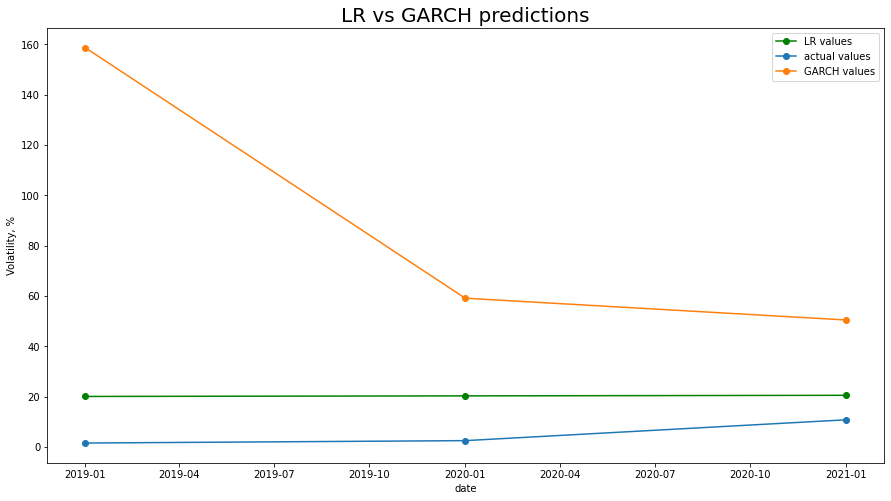

In [110]:
# построение модели линейной регрессии
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data['GDP_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['GDP_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['GDP_vol'].fillna(0)
y_test = test_df['GDP_vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

plt.rcParams["figure.figsize"] = 15, 8
plt.plot(pd.Series(lr_predict, index=y_test.index),marker='o',label='LR values',color='green')
plt.plot(predictions_df["GDP_vol"].abs(),marker='o',label='actual values')
plt.plot(predictions_df["Predictions"],marker='o',label='GARCH values')
plt.legend()
plt.title('LR vs GARCH predictions',size=20)
plt.xlabel('date')
plt.ylabel('Volatility, %');

Оказалось, что с использованием модели линейной регрессии получен существенно лучший результат по сравнению с GARCH. Как известно из теории модель GARCH учитывает при обучении историю поведения дисперсии величины. А в обучающих данных есть значения волатильности, достигающие значений свыше 90 %. Также количество записей в тестовой (а также и в обучающей) выборке невелико, что может оказаться недостаточным для качественного обучения модели.

## **Валидация данных**

Fold 0:
  Train size=41
  Test size=7
Fold 1:
  Train size=48
  Test size=7
Fold 2:
  Train size=55
  Test size=7


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. 

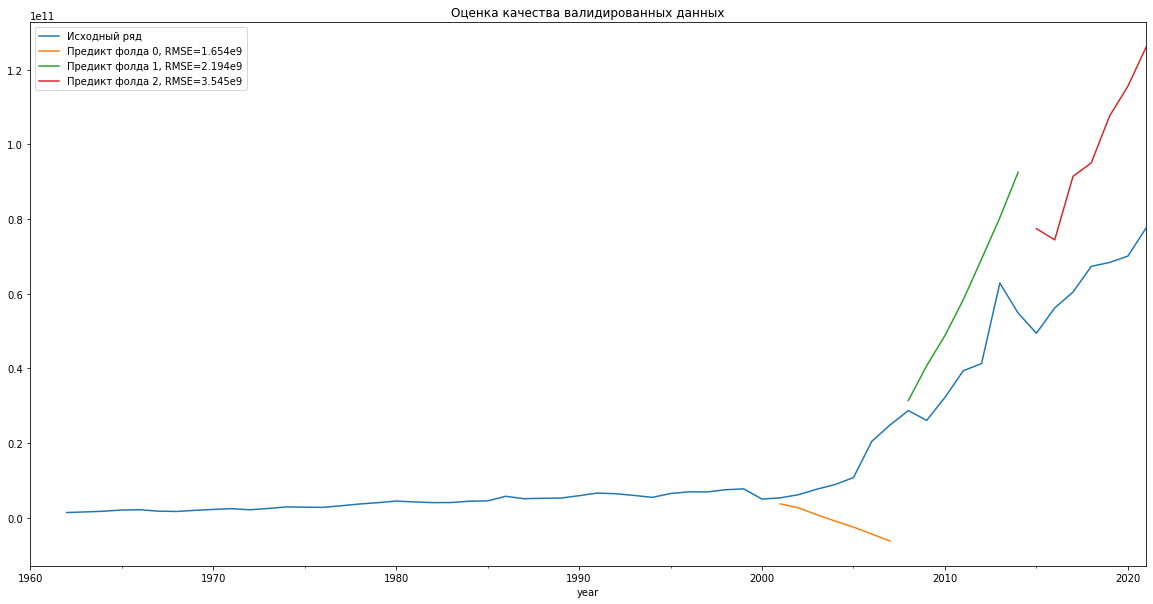

In [111]:
# импорт алгоритма
from sklearn.model_selection import TimeSeriesSplit
# визуализация исходного временного ряда
fig,ax = plt.subplots(figsize=(20,10))
data["GDP"].plot(ax=ax,label='Исходный ряд')
ax.set_title('Оценка качества валидированных данных')
# создание объекта
tscv = TimeSeriesSplit(n_splits=3,test_size=7)
train_test_groups = tscv.split(data["GDP"])
for i, (train_index, test_index) in enumerate(train_test_groups):
  print(f"Fold {i}:")
  print(f"  Train size={train_index.shape[0]}")
  print(f"  Test size={test_index.shape[0]}")
  # обучающая и тестовая выборки
  train_df = data["GDP"].iloc[train_index]
  test_df = data["GDP"].iloc[test_index]
  # создаем модель
  arima_model = ARIMA(train_df, order = (2, 3, 1),freq='YS')
  arima_model_fit = arima_model.fit()
  # предсказание
  predicts = arima_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])
  # оцениваем качество
  rmse = np.sqrt(mean_squared_error(predicts,test_df.values))
  predicts.plot(ax=ax, label=f'Предикт фолда {i}, RMSE={round(rmse/10e9,3)}e9')
ax.legend()
  


Валидация позволяет оценить качество модели на нескольких фолдах. В данном примере реализован метод валидации "множественное разбиение", где каждый последующий фолд представлен более широким набором обучающих данных по сравнению с предыдущим. Судя по визуализации, модель улавливает тренд на 1-м и 2-м фолдах, в 0-м фолде небольшой спад в обучающей выборке повлиял на установление в предсказании тренд к падению, что является ошибочным поведением. При этом по величине ошибки именно результаты в 0-м фолде самые лучшие. Это обусловлено малым трендом данных в обучающей выборке, что позволило получить сравнительно малую среднюю ошибку, в других фолдах из-за возросшей крутизны тренда расхождение предсказанных и реальных значений стало существенно больше, что повлияло на рост RMSE.